In [1]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

In [4]:
class RNN(nn.Module):
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            num_classes: int,
            sequence_length: int,
            rnn_type: str = "GRU",
            device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0"),
    ):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.rnn_type = rnn_type
        
        if self.rnn_type == "RNN":
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
        if self.rnn_type == "GRU":
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)
        
    def forward(self, x):
        # initialize the hidden layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # forward prop
        if self.rnn_type == "LSTM":
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)
        # out = self.fc(out[:, -1,:]) # use the last hidden state
        out = out.reshape(out.shape[0], -1) # use all hidden state
        out = self.fc(out)
        return out
        

In [5]:
# Hyper parameters
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 1
rnn_type = "RNN"

In [6]:
# load data
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
model = RNN(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=num_classes,
    sequence_length=sequence_length,
    rnn_type=rnn_type
).to(device)
# loss functions
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Put the model in training mode
model.train()

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)

In [8]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # set the data to device
        data = data.to(device).squeeze(1)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad() # set all gradients to zero for each batch to avoid storing batch forward calculation
        loss.backward()
        # gradient descent or adam step
        optimizer.step() 
        # add the training loss to the train loses
        train_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # set the model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device).squeeze(1)
                y = y.to(device)
                prediction = model(x)
                val_loss += criterion(prediction, y).item()
        
        val_loss /= len(test_loader)  # Average validation loss
        val_losses.append(val_loss)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

print("Training and validation completed.")

Epoch [1/1], Step [0/938], Loss: 2.2952
Epoch [1/1], Validation Loss: 2.3565
Epoch [1/1], Step [100/938], Loss: 0.4216
Epoch [1/1], Validation Loss: 0.4074
Epoch [1/1], Step [200/938], Loss: 0.4519
Epoch [1/1], Validation Loss: 0.3411
Epoch [1/1], Step [300/938], Loss: 0.3292
Epoch [1/1], Validation Loss: 0.2948
Epoch [1/1], Step [400/938], Loss: 0.2250
Epoch [1/1], Validation Loss: 0.2276
Epoch [1/1], Step [500/938], Loss: 0.0993
Epoch [1/1], Validation Loss: 0.2176
Epoch [1/1], Step [600/938], Loss: 0.2727
Epoch [1/1], Validation Loss: 0.1855
Epoch [1/1], Step [700/938], Loss: 0.3896
Epoch [1/1], Validation Loss: 0.1727
Epoch [1/1], Step [800/938], Loss: 0.1967
Epoch [1/1], Validation Loss: 0.1533
Epoch [1/1], Step [900/938], Loss: 0.1167
Epoch [1/1], Validation Loss: 0.1377
Training and validation completed.


In [9]:
model_path = f"../models/rnn{rnn_type}.pth"

In [10]:
# save the model
torch.save(model.state_dict(), model_path)

In [11]:
model.load_state_dict(torch.load(model_path))
model.eval()

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)

In [12]:
x = np.arange(1, len(train_losses) + 1)

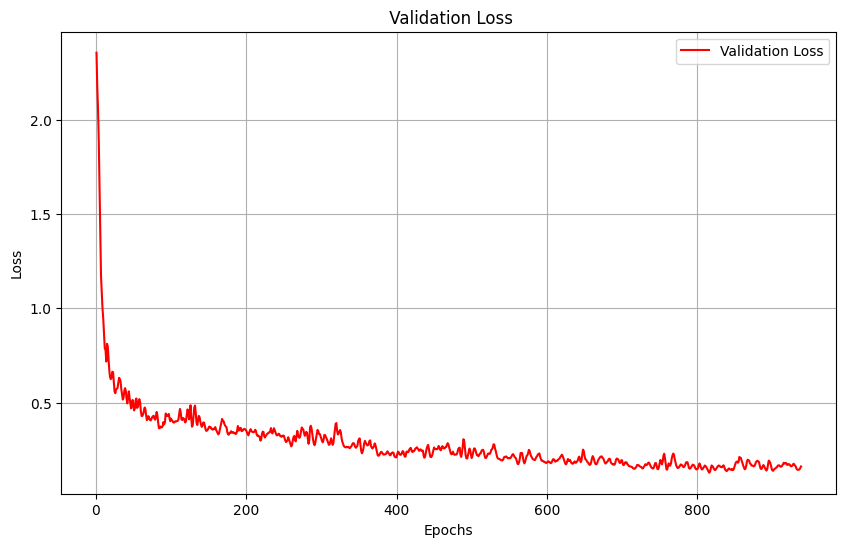

In [13]:
# plot the validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(" Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

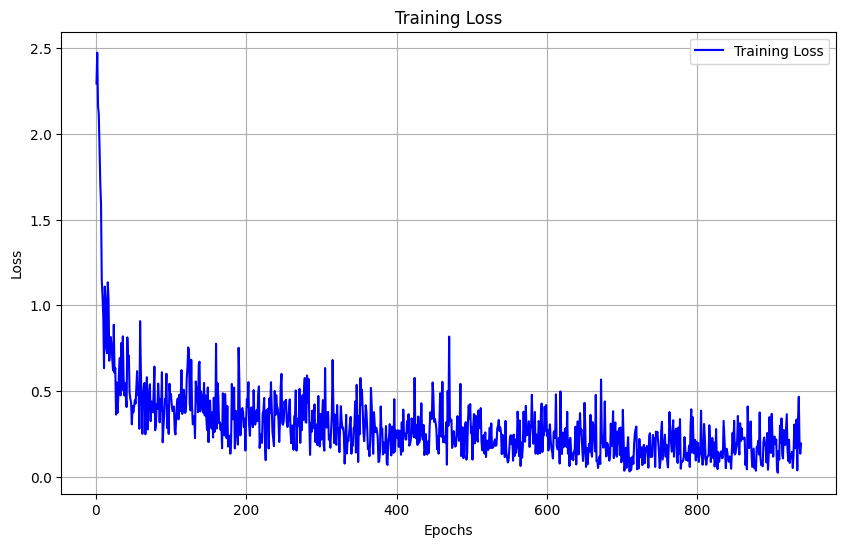

In [14]:
# plot the training
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

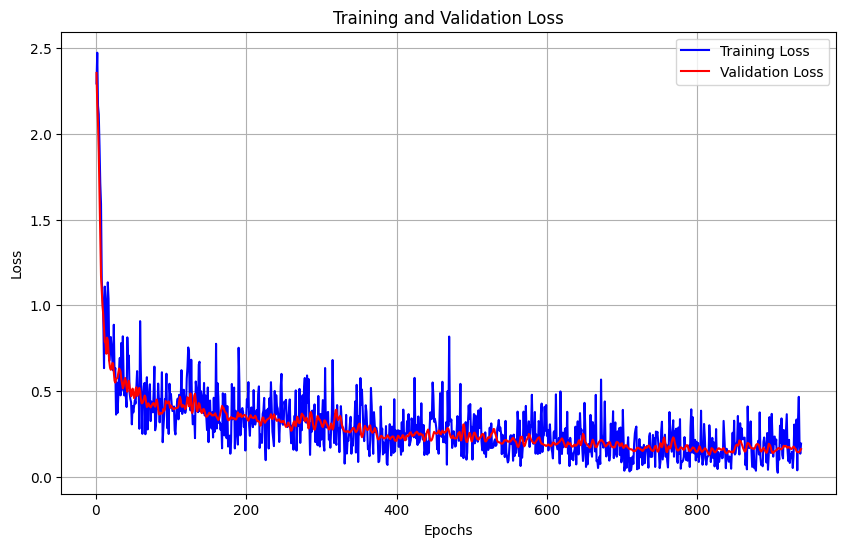

In [15]:
# plot the training and validation loss 
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# check for the accuracy of the model
def check_accuracy(loader, trained_model):
    num_correct = 0
    num_samples = 0
    trained_model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).squeeze(1)
            y = y.to(device)
            pred_scores = trained_model(x)
            _, predictions = pred_scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}")
    print(f"Accuracy: {float(num_correct)/float(num_samples)*100}")

In [17]:
check_accuracy(test_loader, model)

Got 9516 / 10000 with accuracy 95.16
Accuracy: 95.16
